In [1]:
import glob 
from skimage import io 
import matplotlib.pyplot as plt  
from splinter import Browser
from bs4 import BeautifulSoup as soup
from webdriver_manager.chrome import ChromeDriverManager # brew install chromedriver
import pandas as pd
from os.path  import basename
import requests
import base64
import os
import random
import numpy as np
import time

## Scrape Produce Data
### Get Produce Names

In [2]:
executable_path = {'executable_path': ChromeDriverManager().install()} # webdriver to automate chrome
browser = Browser('chrome', **executable_path, headless=False)

# visit fruits and vegitables website
browser.visit('https://fruitsandveggies.org/stories/fruit-and-veggie-color-list/')
fruitnveg_soup = soup(browser.html, 'html.parser') # convert to soup object
produce = fruitnveg_soup.table.find_all('a') # find all fruits and vegetables
for item in range(len(produce)): # extract names from soup object
    produce[item] = produce[item].get_text() # add current item to list

print('There are '+str(len(produce))+' Produce items considered')   
print(produce[:5])

There are 121 Produce items considered
['Red Apples', 'Blood Oranges', 'Cherries', 'Cranberries', 'Red Grapes']


### Get Produce Pictures

In [3]:
def download_images(links, name, dirname, j):    
    png_array=  links
    png_array = png_array.split(",")
    png_array = png_array[1].encode()
    pathImg = dirname+'/'+name+str(j)+'.png'
    fh = open(pathImg, "wb")
    fh.write(base64.decodebytes(png_array))
    fh.close()

produce_table = {'nameId':[],'name':[],'width':[],'height':[],'encodedPic':[]} # Initialize DataFrame
for item in produce:
    if item != '': # If item is not null
        item = item.replace(' ','_') # Clean name
        image_path = 'Pictures/'+item
        try:
            os.mkdir(image_path) # Create directory to hold fruit-pics
        except:
            print('Directory Exists')

        home = 'https://images.google.com/' # Define 'Homepage'
        browser.visit(home) # Go to google
        time.sleep(random.random()*random.randint(1,6)) # Randomization, avoids chromes CAPTCHA
        browser.find_by_xpath( # Fill item
            '/html/body/div[1]/div[3]/form/div[1]/div[1]/div[1]/div/div[2]/input'
        ).fill(item)
        time.sleep(random.random()*random.randint(1,3))
        browser.find_by_xpath( # Click search button
            '/html/body/div[1]/div[3]/form/div[1]/div[1]/div[1]/button'
        ).click()

        Picture_soup = soup(browser.html, 'html.parser') # Convert Item Image Page to Soup
        Produce_Item_Images = Picture_soup.find_all('img') # Get all Images of Item
        j=0 # initailize counter
        for i in range(len(Produce_Item_Images)): # Download top images
            if Produce_Item_Images[i].get('data-deferred') == '1': # If top images
                lnk = Produce_Item_Images[i].get('src') # Get src
                try:
                    download_images(lnk, item, image_path, j) # Download image with unique naming
                    new_image_path = image_path+'/'+item+str(j)+'.png'
                    get_encoding = glob.glob(new_image_path)
                    image = io.imread(get_encoding[0]) # Encode Image in RGB
                    width = len(image)
                    height = len(image[0])
                    if width != 100 and height != 100: # If not square Image
                        middle_width = width//2 # Crop based on center
                        middle_height = height//2
                        image = image[middle_width-50:middle_width+50,middle_height-50:middle_height+50]
                    if type(image) != None:
                        produce_table['nameId'].append(new_image_path) # Add attributes to DataFrame
                        produce_table['name'].append(item) 
                        produce_table['width'].append(len(image[0])) # Double check images were cropped
                        produce_table['height'].append(len(image)) 
                        produce_table['encodedPic'].append(image)            
                        
                except:
                    status = 'nah'
                    
                j += 1

Directory Exists


In [6]:
raw_produce = pd.DataFrame(produce_table)
raw_produce.drop('encodedPic',1).head()

/var/folders/2w/9nbxjyl94ds7lmb56xcp0vd00000gn/T/ipykernel_5627/326611397.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  raw_produce.drop('encodedPic',1).sort_values('height').head(25)


,nameId,name,width,height
0,Pictures/Red_Apples/Red_Apples0.png,Red_Apples,100,100
2492,Pictures/Broccoli/Broccoli31.png,Broccoli,100,100
2493,Pictures/Broccoli_Rabe/Broccoli_Rabe0.png,Broccoli_Rabe,100,100
2494,Pictures/Broccoli_Rabe/Broccoli_Rabe1.png,Broccoli_Rabe,100,100
2495,Pictures/Broccoli_Rabe/Broccoli_Rabe2.png,Broccoli_Rabe,100,100
2496,Pictures/Broccoli_Rabe/Broccoli_Rabe3.png,Broccoli_Rabe,100,100
2497,Pictures/Broccoli_Rabe/Broccoli_Rabe4.png,Broccoli_Rabe,100,100
2498,Pictures/Broccoli_Rabe/Broccoli_Rabe5.png,Broccoli_Rabe,100,100
2499,Pictures/Broccoli_Rabe/Broccoli_Rabe6.png,Broccoli_Rabe,100,100
2500,Pictures/Broccoli_Rabe/Broccoli_Rabe7.png,Broccoli_Rabe,100,100


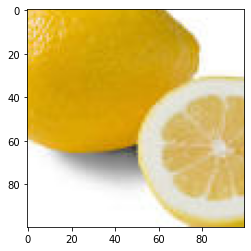

In [7]:
image = raw_produce['encodedPic'][834]
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
im1.imshow(image)

### Import Photos